# DNSC 6290 Large Datasets Group Project

## Group 6——PUBG Match Deaths and Statistics

Create SparkContext and SparkSession:

In [1]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test SparkSession") \
     .getOrCreate()

#Remember to close sc at the end

In [4]:
spark

Load packages.

In [5]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import seaborn as sns
import matplotlib.cm as cm

import pyspark.sql.functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, precision_score, recall_score 

### 1. Load and Prepare Data

We need to stack all five aggregate files into one file, as well as stacking all five deaths files into one. 

In [6]:
#This command read every file in the "aggregate" folder
aggr_all = spark.read.option("header", "true") \
    .option("delimiter", ",") \
    .option("inferSchema", "true") \
    .csv("s3://bigdata2020group6/aggregate/agg_match_stats_*.csv")

In [6]:
aggr_all.count() #67369236 rows in total

67369231

In [7]:
#This command read every file in the "deaths" folder
death_all = spark.read.option("header", "true") \
    .option("delimiter", ",") \
    .option("inferSchema", "true") \
    .csv("s3://bigdata2020group6/deaths/kill_match_stats_final_*.csv")

In [8]:
death_all.count() #65370480 rows in total

65370475

### 2. Explore Data Structure and Clean Data

In [9]:
aggr_all.show(10)

+--------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+
|                date|game_size|            match_id|match_mode|party_size|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+--------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+
|2017-11-26T20:59:...|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|          2870.724|        1784.84778|       117|           1|   SnuffIes|            1106.32|      4|            18|
|2017-11-26T20:59:...|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|2938.4072300000003

In [10]:
death_all.show(10)

+------------+----------------+----------------+-----------------+-----------------+-------+--------------------+----+---------------+----------------+-----------------+-----------------+
|   killed_by|     killer_name|killer_placement|killer_position_x|killer_position_y|    map|            match_id|time|    victim_name|victim_placement|victim_position_x|victim_position_y|
+------------+----------------+----------------+-----------------+-----------------+-------+--------------------+----+---------------+----------------+-----------------+-----------------+
|     Grenade| KrazyPortuguese|             5.0|         657725.1|         146275.2|MIRAMAR|2U4GBNA0YmnLSqvEy...| 823|KrazyPortuguese|             5.0|         657725.1|         146275.2|
|      SCAR-L|nide2Bxiaojiejie|            31.0|         93091.37|         722236.4|MIRAMAR|2U4GBNA0YmnLSqvEy...| 194|    X3evolution|            33.0|         92238.68|         723375.1|
|        S686|        Ascholes|            43.0|         366

Check on the variable type for each column: 

In [12]:
death_all.printSchema

<bound method DataFrame.printSchema of DataFrame[killed_by: string, killer_name: string, killer_placement: double, killer_position_x: double, killer_position_y: double, map: string, match_id: string, time: int, victim_name: string, victim_placement: double, victim_position_x: double, victim_position_y: double]>

In [11]:
aggr_all.printSchema

<bound method DataFrame.printSchema of DataFrame[date: string, game_size: int, match_id: string, match_mode: string, party_size: int, player_assists: int, player_dbno: int, player_dist_ride: double, player_dist_walk: double, player_dmg: int, player_kills: int, player_name: string, player_survive_time: double, team_id: int, team_placement: int]>

Check NA in each column: 

In [15]:
aggr_all.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in aggr_all.columns]).show()

+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|date|game_size|match_id|match_mode|party_size|player_assists|player_dbno|player_dist_ride|player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|   0|        0|       0|         0|         0|             0|          0|               0|               0|         0|           0|      97653|                  0|      0|             0|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+



In [17]:
death_all.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in death_all.columns]).show()

+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+
|killed_by|killer_name|killer_placement|killer_position_x|killer_position_y|   map|match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|
+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+
|        0|    4517469|         4517469|          4517469|          4517469|783392|       0|   0|          0|         1227694|                0|                0|
+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+



Drop NA or Fill in Value for NA：

In [50]:
aggr_all = aggr_all.filter(aggr_all.player_name.isNotNull())

In [39]:
death_all = death_all.filter(death_all.map.isNotNull())

In [40]:
death_all = death_all.filter(death_all.victim_placement.isNotNull())

In [64]:
death_all = death_all.fillna({'killer_name':'NaN'})

In [48]:
death_all = death_all.fillna({'killer_placement':'0'})

In [58]:
death_all = death_all.fillna({'killer_position_x':'0'})
death_all = death_all.fillna({'killer_position_y':'0'})

In [90]:
aggr_all.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in aggr_all.columns]).show()

+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|date|game_size|match_id|match_mode|party_size|player_assists|player_dbno|player_dist_ride|player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|   0|        0|       0|         0|         0|             0|          0|               0|               0|         0|           0|          0|                  0|      0|             0|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+



In [59]:
death_all.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in death_all.columns]).show()

+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+
|killed_by|killer_name|killer_placement|killer_position_x|killer_position_y|map|match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|
+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+
|        0|    4455678|               0|                0|                0|  0|       0|   0|          0|               0|                0|                0|
+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+



For killer position = 0, we let killer position = victim position:

In [75]:
death_all = death_all.withColumn('killer_position_x', \
                     F.when(death_all.killer_position_x == 0,death_all.victim_position_x).otherwise(death_all['killer_position_x']))
                     

In [76]:
death_all = death_all.withColumn('killer_position_y', \
                     F.when(death_all.killer_position_y == 0,death_all.victim_position_y).otherwise(death_all['killer_position_y']))
                     

For victim position = 0, we let victim position = killer position:

In [81]:
death_all = death_all.withColumn('victim_position_x', \
                     F.when(death_all.victim_position_x == 0,death_all.killer_position_x).otherwise(death_all['victim_position_x']))
    

In [82]:
death_all = death_all.withColumn('victim_position_y', \
                     F.when(death_all.victim_position_y == 0,death_all.killer_position_y).otherwise(death_all['victim_position_y']))
    

For case where both killer and victime position = 0, we drop these rows:

In [85]:
death_all = death_all.filter(death_all.victim_position_x != 0)

In [86]:
death_all.where(col("victim_position_x") == 0).count()

0

In [87]:
death_all.where(col("victim_position_y") == 0).count()

0

In [88]:
death_all.where(col("killer_position_x") == 0).count()

0

In [89]:
death_all.where(col("killer_position_y") == 0).count()

0

### 3. Analyze Data

Since the total number of parties varies, we split aggregate dateframe into three dfs based on party_size.   
For Party size =1, there are up to 100 parties in a game.   
For Party size =2, there are up to 50 parities in a game.  
For Party size = 4, tehre are up to 25 parties in a game.  

In [22]:
single = aggr_all.filter(F.col("party_size") == 1)
double = aggr_all.filter(F.col("party_size") == 2)
quadruple = aggr_all.filter(F.col("party_size") == 4)

#### (1) SQL:

##### a. Which locations is "dangerous" for parachuting? 

In [92]:
aggr_all.createOrReplaceTempView("aggr")
death_all.createOrReplaceTempView("death")  

In [24]:
location = spark.sql("""
             select victim_position_x as X, victim_position_y as Y,time as Time,map as Map from death
             where time<120
             order by time asc
          """).cache()

In [25]:
location.show(10)

+--------+--------+----+-------+
|       X|       Y|Time|    Map|
+--------+--------+----+-------+
|793642.1|20216.34|  23|ERANGEL|
|326611.7|588506.9|  28|ERANGEL|
|463199.8| 6090.61|  32|MIRAMAR|
|132976.3| 8953.52|  33|MIRAMAR|
|180589.4| 7373.03|  33|MIRAMAR|
|528533.3| 8006.34|  33|MIRAMAR|
|170921.9| 7790.76|  34|MIRAMAR|
|239040.5| 6733.71|  34|MIRAMAR|
|521694.0| 7921.38|  34|MIRAMAR|
|148092.8| 8481.53|  34|MIRAMAR|
+--------+--------+----+-------+
only showing top 10 rows



In [26]:
location.count()

3560172

Plot:

In [27]:
location_df=pd.DataFrame(location.collect())

In [28]:
location_df = location_df.rename(columns={0: "X", 1: "Y",2:"Time",3:"Map"})

In [29]:
location_df = location_df.drop("Time",axis=1)

In [32]:
len(location_df)
location_df = location_df.dropna()
len(location_df)

3560172

In [38]:
location_df.head()

,X,Y,Map
0,793642.1,20216.34,ERANGEL
1,326611.7,588506.90,ERANGEL
2,463199.8,6090.61,MIRAMAR
3,132976.3,8953.52,MIRAMAR
4,180589.4,7373.03,MIRAMAR


In [42]:
location_df_er = location_df[location_df["Map"]=="ERANGEL"]
location_df_mi = location_df[location_df["Map"]=="MIRAMAR"]

In [43]:
position = ["X","Y"]
location_df_er = location_df_er[position].apply(lambda x: x* 4096/800000)
location_df_mi = location_df_mi[position].apply(lambda x: x* 1000/800000)
location_df_er = location_df_er[location_df_er[position] != 0]
location_df_mi = location_df_mi[location_df_mi[position] != 0]
location_df_er = location_df_er.dropna()
location_df_mi = location_df_mi.dropna()

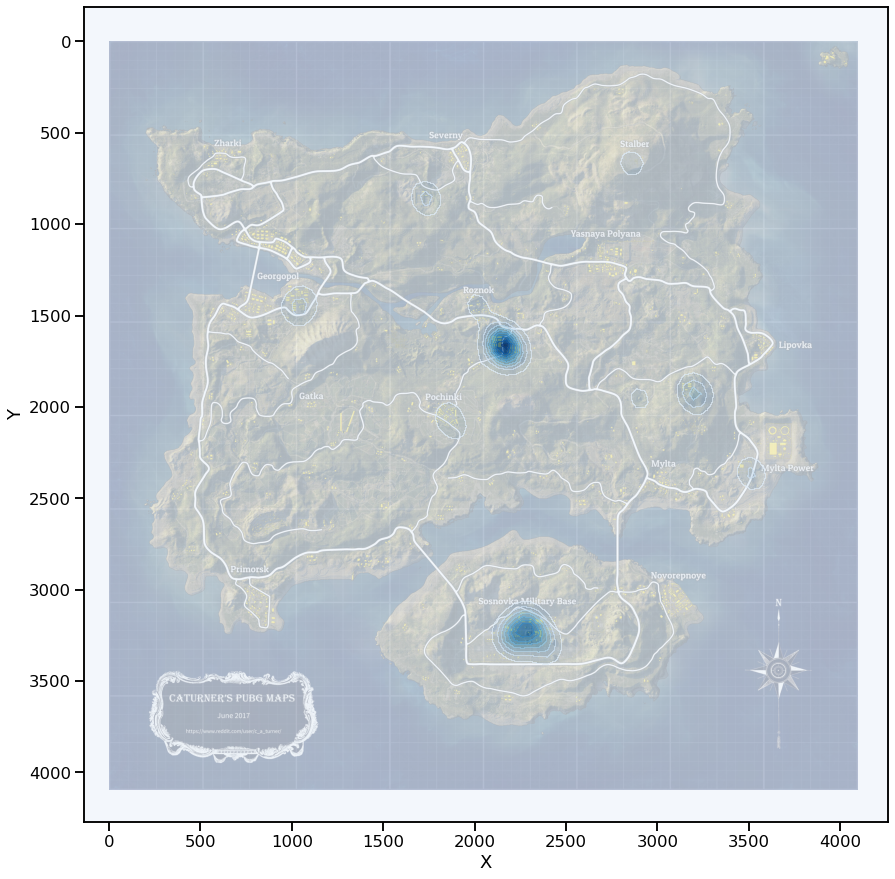

In [50]:
sns.set_context('talk')
bg = imread( "erangel.jpg")
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(bg)
sns.kdeplot(location_df_er["X"], location_df_er["Y"], cmap="coolwarm", alpha= 0.7, shade=True)

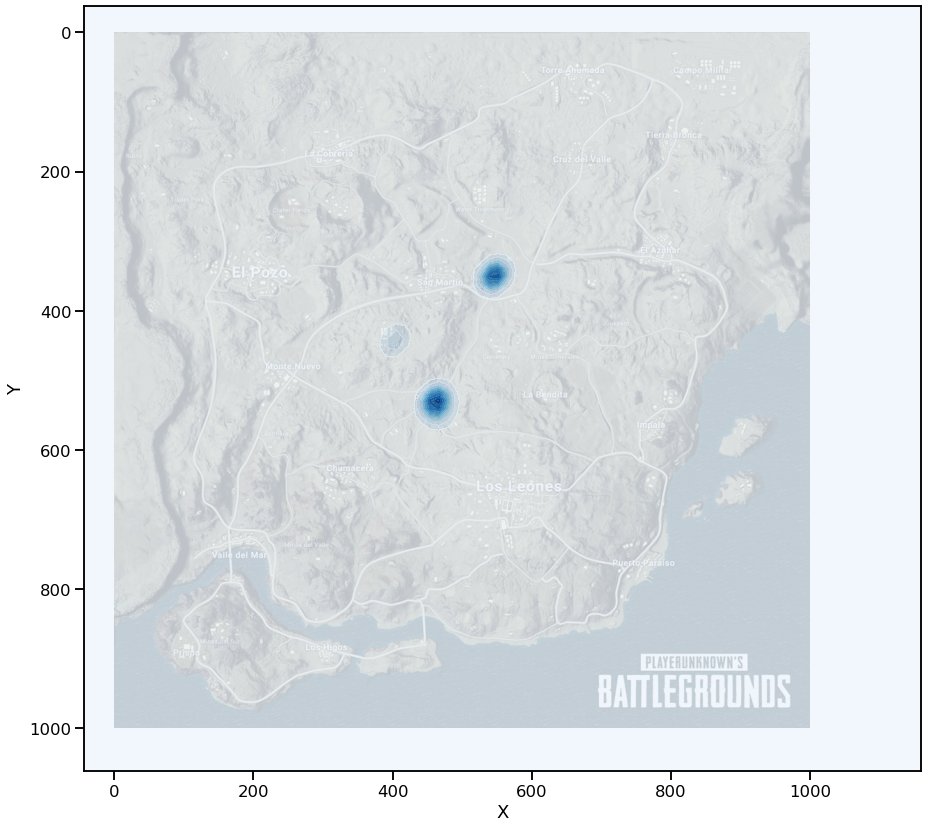

In [51]:
bg = imread( "miramar.jpg")
fig, ax = plt.subplots(1,1,figsize=(15, 15))
ax.imshow(bg)
sns.kdeplot(location_df_mi["X"], location_df_mi["Y"], cmap="coolwarm", alpha= 0.8, shade=True)

##### b. Player's placement vs Number of enemies killed

In [23]:
single.createOrReplaceTempView("single")
double.createOrReplaceTempView("double")  
quadruple.createOrReplaceTempView("quadruple")

Note: due to certain situations, such like quit the game in the midway, some teams have placement = 0.

In [33]:
aggr_all.where(col("team_placement") == 0).count()

21

These rows are kept since they are part of the game statistics. Here, we filtered out cases when team_placement = 0.

In [24]:
#Party Size = 1
party1_kill = spark.sql("""
             select team_placement as rank , avg(player_kills) as avg_kills from single
             where team_placement != 0
             group by team_placement
             order by team_placement asc
          """).cache()

In [25]:
party1_kill.show(10)

+----+------------------+
|rank|         avg_kills|
+----+------------------+
|   1| 6.970846857480082|
|   2| 3.599979000144374|
|   3|3.0568580976829995|
|   4| 2.708515111695138|
|   5|  2.47160518182416|
|   6| 2.285916429187261|
|   7| 2.144181446561614|
|   8|  2.01534766485873|
|   9|1.9034656409849717|
|  10|1.8151479399756085|
+----+------------------+
only showing top 10 rows



In [26]:
#Party Size = 2
party2_kill = spark.sql("""
             select team_placement as rank , avg(player_kills) as avg_kills from double
             where team_placement != 0
             group by team_placement
             order by team_placement asc
          """).cache()

In [27]:
party2_kill.show(10) 

+----+------------------+
|rank|         avg_kills|
+----+------------------+
|   1| 4.416512205489827|
|   2|2.5763982214079224|
|   3|2.2311533877941216|
|   4|1.9527973618868921|
|   5|1.7622350599079941|
|   6|1.6203774044897594|
|   7|1.5054382262074872|
|   8|1.4006394631320518|
|   9|1.3206494950410355|
|  10|1.2406571575258376|
+----+------------------+
only showing top 10 rows



In [28]:
#Party Size = 4
party4_kill = spark.sql("""
             select team_placement as rank , avg(player_kills) as avg_kills from quadruple
             where team_placement != 0
             group by team_placement
             order by team_placement asc
          """).cache()

In [29]:
party4_kill.show(10) 

+----+------------------+
|rank|         avg_kills|
+----+------------------+
|   1| 2.937261017288994|
|   2|1.7871176501136514|
|   3|1.5751676654505462|
|   4|1.3730355960439127|
|   5|1.2366525816118643|
|   6|1.1366548365049696|
|   7| 1.051095615368824|
|   8|0.9775038751257716|
|   9|0.9118165067424356|
|  10| 0.853479020254573|
+----+------------------+
only showing top 10 rows



##### c. Kill Distance vs Kill By

In [93]:
distance_kill_by_near = spark.sql("""
             select killed_by as wheapons, avg(power((power((killer_position_x-victim_position_x),2)+power((killer_position_y-victim_position_y),2)),(1/2))) as distance from death
             group by wheapons
             Having distance > 0
             order by distance asc
          """).cache()

In [94]:
distance_kill_by_near.show(10)

+--------------------+------------------+
|            wheapons|          distance|
+--------------------+------------------+
|             RedZone|265.96624028058244|
|               Punch|274.88406972266023|
|           Motorbike|293.41564707758897|
|              Sickle| 303.0226601107962|
|             Crowbar|312.37976410281595|
|death.ProjMolotov...| 312.7061157538787|
|                 Pan| 334.2329013038818|
|             Machete| 358.4467341685377|
| death.ProjMolotov_C| 403.4910418582187|
| Motorbike (SideCar)| 480.7441403008571|
+--------------------+------------------+
only showing top 10 rows



In [95]:
distance_kill_by_far = spark.sql("""
             select killed_by as wheapons, avg(power((power((killer_position_x-victim_position_x),2)+power((killer_position_y-victim_position_y),2)),(1/2))) as distance from death
             group by wheapons
             Having distance > 0
             order by distance desc
          """).cache()

In [96]:
distance_kill_by_far.show(10)

+------------+------------------+
|    wheapons|          distance|
+------------+------------------+
|         M24|15152.866619321454|
|         AWM|15099.260264442826|
|        Mk14| 13604.54002499796|
|        Boat|13072.815020600918|
|      Kar98k|12878.874448503808|
|         SKS| 9533.690294314252|
|     Mini 14| 8710.399947138982|
|         Uaz| 6195.537423169282|
|Down and Out| 5925.426339789711|
|         VSS| 5694.080947321125|
+------------+------------------+
only showing top 10 rows



In [98]:
#Create Pandas dataframe to make plot 
distance_kill_by_near_plt = pd.DataFrame(distance_kill_by_near.collect())
distance_kill_by_far_plt = pd.DataFrame(distance_kill_by_far.collect())

d.Kill by wheapons

Wheapons count if player are in first place

In [51]:
wheapons_fir = spark.sql("""
             select killed_by as wheapons, count(killed_by) as count from death
             where victim_placement==2 and killer_placement==1
             group by killed_by
             order by count desc
          """).cache()

In [52]:
wheapons_fir.show(10)

+------------+------+
|    wheapons| count|
+------------+------+
|Down and Out|261364|
|        M416|230938|
|      SCAR-L|165638|
|       M16A4| 84685|
|         AKM| 70058|
|      Kar98k| 51019|
|     Grenade| 44625|
|     Mini 14| 42468|
|         SKS| 29374|
|    Bluezone| 25389|
+------------+------+
only showing top 10 rows



Wheapons count if player rank are between 2 to 10

In [53]:
wheapons_sec_ten = spark.sql("""
             select killed_by as wheapons, count(killed_by) as count from death
             where victim_placement>2 and victim_placement<11
             group by killed_by
             order by count desc
          """).cache()

In [54]:
wheapons_sec_ten.show(10)

+------------+-------+
|    wheapons|  count|
+------------+-------+
|Down and Out|3255373|
|        M416|2031640|
|      SCAR-L|1531037|
|    Bluezone|1148048|
|       M16A4|1071318|
|         AKM| 930885|
|      Kar98k| 615815|
|     Mini 14| 547421|
|         SKS| 415367|
|        UMP9| 410707|
+------------+-------+
only showing top 10 rows



M416 and SCAR-L are the most powerful weapons in the finals. Besides, there are many players eliminated by blue zone.

### (2) Modeling:

#### Linear Regression Model

We want to predict the pencentage of placement for a player given the player's information from the game. Frist, we create a continuous response variable "team_placement_percent" by deviding game_size by team_placement. The variable is between 0 and 1.

In [15]:
aggr_lr = spark.sql("""
             select player_assists, player_dbno, player_dist_ride, player_dist_walk, player_dmg, player_kills, player_survive_time, (team_placement/game_size) as team_placement_percent from aggr
          """).cache()

In [21]:
aggr_lr.show(10)

+--------------+-----------+------------------+------------------+----------+------------+-------------------+----------------------+
|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_survive_time|team_placement_percent|
+--------------+-----------+------------------+------------------+----------+------------+-------------------+----------------------+
|             0|          1|          2870.724|        1784.84778|       117|           1|            1106.32|    0.4864864864864865|
|             0|          1|2938.4072300000003|1756.0797100000002|       127|           1|           1106.315|    0.4864864864864865|
|             0|          0|               0.0|        224.157562|        67|           0|            235.558|    0.8918918918918919|
|             0|          0|               0.0|          92.93515|         0|           0|            197.553|    0.8918918918918919|
|             0|          0|        2619.07739|          2510.

In [35]:
#Check the schema of the dataframe
aggr_lr.printSchema()

root
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: double (nullable = true)
 |-- player_dist_walk: double (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_survive_time: double (nullable = true)
 |-- team_placement_percent: double (nullable = true)



Use a VectorAssembler to put features into a feature vector column, then standardize the column.

In [95]:
# Put features into a feature vector column
lr_vectorAssembler = VectorAssembler(inputCols=aggr_lr.columns[0:7], outputCol="features") 
lr_df_assembled= lr_vectorAssembler.transform(aggr_lr)
# Initialize the `standardscaler`
lr_standardscaler = StandardScaler(inputCol="features", outputCol="features_scaled")
# Fit the DataFrame to the scaler
aggr_lr_scaled = lr_standardscaler.fit(lr_df_assembled).transform(lr_df_assembled)

In [44]:
aggr_lr_scaled.select("features", "features_scaled").show(10, truncate=False)

+------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------+
|features                                                          |features_scaled                                                                                                           |
+------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------+
|[0.0,1.0,2870.724,1784.84778,117.0,1.0,1106.32]                   |[0.0,0.8932701747523498,1.4355514323995076,0.42385941239565805,0.6902896486372273,0.643366147293223,2.1267942459747707E-5]|
|[0.0,1.0,2938.4072300000003,1756.0797100000002,127.0,1.0,1106.315]|[0.0,0.8932701747523498,1.4693975136584254,0.41702767168219673,0.7492887639053664,0.643366147293223,2.126784633953629E-5] |
|(7,[3,4,6],[224.157562,67.0,235.558])  

Split the data into training and testing sets.

In [96]:
# Split the data into train and test sets
lr_training, lr_testing = aggr_lr_scaled.randomSplit([.8,.2], seed = 123)

In [48]:
lr_training.columns

['player_assists',
 'player_dbno',
 'player_dist_ride',
 'player_dist_walk',
 'player_dmg',
 'player_kills',
 'player_survive_time',
 'team_placement_percent',
 'features',
 'features_scaled']

GLM: team_rank_percent ~ player_assists + player_dbno + player_dist_ride + player_dist_walk + player_dmg + player_kills + player_survive_time

In [102]:
# Perform linear regression on training set
lr_obj = LinearRegression(
    featuresCol = "features_scaled",
    labelCol = "team_placement_percent",
    predictionCol='pred_team_placement_percent',
    maxIter=10,
    regParam=0.01,
    elasticNetParam=0.8,
    standardization=False)

lr_model = lr_obj.fit(lr_training)

In [103]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

# Summarize the model over the training set and print out some metrics
lr_trainingSummary = lr_model.summary
print("numIterations: %d" % lr_trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(lr_trainingSummary.objectiveHistory))
lr_trainingSummary.residuals.show()
print("Training RMSE: %f" % lr_trainingSummary.rootMeanSquaredError)
print("Training MAE: %f" % lr_trainingSummary.meanAbsoluteError)
print("Training R2: %f" % lr_trainingSummary.r2)

Coefficients: [-0.0260879264112184,0.0127526420109073,-0.11465069683318516,-0.016284664043906927,-0.04770343995043305,-0.03720789276976806,0.0]
Intercept: 0.6504091972992156
numIterations: 11
objectiveHistory: [0.5, 0.46616537472261216, 0.352848213683288, 0.3461129464900098, 0.3440951557425606, 0.34404762413968765, 0.3440308232951486, 0.3440254341276111, 0.3440237921153814, 0.34402293755324215, 0.3440201997521782]
+-------------------+
|          residuals|
+-------------------+
|0.34959080270078435|
|0.34959080270078435|
|0.34959080270078435|
|0.05329450640448807|
|0.34959080270078435|
|0.34959080270078435|
|0.34959080270078435|
|0.34959080270078435|
|0.34959080270078435|
|0.34959080270078435|
|-0.5170758639658823|
|0.34959080270078435|
|0.34959080270078435|
|0.33883811452874135|
|0.34959080270078435|
|0.34959080270078435|
|0.34959080270078435|
| 0.3291826394354782|
|0.34959080270078435|
|0.34959080270078435|
+-------------------+
only showing top 20 rows

RMSE: 0.234849
MAE: 0.192014

The model does not perform well on training set.

Make predictions.

In [53]:
# Generate predictions
lr_predictions = lr_model.transform(testing)

In [54]:
# Extract the predictions and the "known" correct labels
lr_predandlabels = lr_predictions.select("pred_team_placement_percent", "team_placement_percent")

In [68]:
lr_predandlabels.show(20)

+---------------------------+----------------------+
|pred_team_placement_percent|team_placement_percent|
+---------------------------+----------------------+
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                   1.0|
|         0.6486733675863761|                 

Use the RegressionEvaluator to evaluate model fitting.

In [63]:
lr_evaluator = RegressionEvaluator(predictionCol="pred_team_placement_percent", labelCol="team_placement_percent", metricName="rmse")
print("Testing RMSE: %f" % lr_evaluator.evaluate(lr_predandlabels))

RMSE: 0.234890


In [64]:
lr_evaluator = RegressionEvaluator(predictionCol="pred_team_placement_percent", labelCol="team_placement_percent", metricName="mae")
print("Testing MAE: %f" % lr_evaluator.evaluate(lr_predandlabels))

MAE: 0.192901


In [65]:
lr_evaluator = RegressionEvaluator(predictionCol="pred_team_placement_percent", labelCol="team_placement_percent", metricName="r2")
print("Testing R2: %f" % lr_evaluator.evaluate(lr_predandlabels))

R2: 0.360317


The linear regression model needs to be improved.

#### Logistic Regression

We want to predict whether a player can be placed top 10% given the player's information from the game. Frist, we create a continuous variable "team_placement_percent" by deviding game_size by team_placement. The variable is between 0 and 1. Then we create a binary response variable "team_placement_top10_percent" based on "team_placement_percent". Since we have created "team_placement_percent" in the dataframe "aggr_lr", we can directly employ it.

In [16]:
#Create response variable
aggr_log = aggr_lr.withColumn('team_placement_top10_percent', F.when((F.col("team_placement_percent") <= 0.1), 1) \
                              .otherwise(0)).cache()

In [17]:
#Delete redundant column from the dataframe.
aggr_log = aggr_log.drop("team_placement_percent")

In [18]:
aggr_log.show(20)

+--------------+-----------+------------------+------------------+----------+------------+-------------------+----------------------------+
|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_survive_time|team_placement_top10_percent|
+--------------+-----------+------------------+------------------+----------+------------+-------------------+----------------------------+
|             0|          1|          2870.724|        1784.84778|       117|           1|            1106.32|                           0|
|             0|          1|2938.4072300000003|1756.0797100000002|       127|           1|           1106.315|                           0|
|             0|          0|               0.0|        224.157562|        67|           0|            235.558|                           0|
|             0|          0|               0.0|          92.93515|         0|           0|            197.553|                           0|
|             0|    

In [19]:
# Put features into a feature vector column
log_vectorAssembler = VectorAssembler(inputCols=aggr_log.columns[0:7], outputCol="features") 
log_df_assembled= log_vectorAssembler.transform(aggr_log)
# Initialize the `standardscaler`
log_standardscaler = StandardScaler(inputCol="features", outputCol="features_scaled")
# Fit the DataFrame to the scaler
aggr_log_scaled = log_standardscaler.fit(log_df_assembled).transform(log_df_assembled)

In [20]:
#Select scaled features and label
aggr_log_scaled = aggr_log_scaled.select("features_scaled","team_placement_top10_percent").cache()

In [21]:
# #Rename the columns
# aggr_log_scaled = aggr_log_scaled.withColumnRenamed("features_scaled", "features")\
#                                  .withColumnRenamed("team_placement_top10_percent", "label").cache()

In [22]:
aggr_log_scaled.show(20, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+----------------------------+
|features_scaled                                                                                                           |team_placement_top10_percent|
+--------------------------------------------------------------------------------------------------------------------------+----------------------------+
|[0.0,0.8932701747523498,1.4355514323995076,0.42385941239565805,0.6902896486372273,0.643366147293223,2.1267942459747707E-5]|0                           |
|[0.0,0.8932701747523498,1.4693975136584254,0.41702767168219673,0.7492887639053664,0.643366147293223,2.126784633953629E-5] |0                           |
|(7,[3,4,6],[0.05323215434840236,0.39529407229653185,4.528376952358495E-6])                                                |0                           |
|(7,[3,6],[0.022069914595127176,3.7977672253511992E-6])                     

In [23]:
# Split the data into train and test sets
log_training, log_testing = aggr_log_scaled.randomSplit([.8,.2], seed = 123)

In [24]:
log_training.columns

['features_scaled', 'team_placement_top10_percent']

Use the best model from CV and retrain the model.

In [25]:
# Perform logistic regression to make binary classification
log_obj  = LogisticRegression(
    featuresCol = "features_scaled",
    labelCol = "team_placement_top10_percent",
    predictionCol='pred_team_placement_top10_percent',
    maxIter=10,
    regParam=0.01,
    elasticNetParam=0.8,
    standardization=False)
# Fit the model
log_model = log_obj.fit(log_training)

In [26]:
# Print the coefficients and intercepts for logistic regression with binomial family
print("Binomial coefficients: %s" % str(log_model.coefficients))
print("Binomial intercepts: %s" % str(log_model.intercept))

# Summarize the model over the training set and print out some metrics
log_trainingSummary = log_model.summary
print("numIterations: %d" % log_trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(log_trainingSummary.objectiveHistory))
print("Training AUC: %s" % str(log_trainingSummary.areaUnderROC))

Binomial coefficients: [0.24966444585162104,-0.1646977112132193,0.48217600168723335,0.2459656360639068,0.2263597708133705,0.5041912475442798,0.0]
Binomial intercepts: -3.5404736883365286
numIterations: 11
objectiveHistory: [0.2935747721745055, 0.2867244033092698, 0.2696547920684046, 0.26026597259159634, 0.2574862729749106, 0.24336842589508048, 0.24183775603871513, 0.2417179368958688, 0.2416056557639384, 0.24146359227749045, 0.2413062711609207]
Training AUC: 0.8505630796267378


In [28]:
# Generate predictions
log_predictions = log_model.transform(log_testing)

In [29]:
# Extract the predictions and the "known" correct labels
log_predandlabels = log_predictions.select("pred_team_placement_top10_percent", "team_placement_top10_percent")

In [34]:
log_evaluator = BinaryClassificationEvaluator(rawPredictionCol="pred_team_placement_top10_percent",labelCol="team_placement_top10_percent")
print("Testing AUC: %s" % log_evaluator.evaluate(log_predandlabels))

Testing AUC: 0.5742351253417569


In [63]:
log_tp = float(log_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 1").count())
log_fp = float(log_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 0").count())
log_tn = float(log_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 0").count())
log_fn = float(log_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 1").count())
log_pr = log_tp / (log_tp + log_fp)
log_re = log_tp / (log_tp + log_fn)
log_metrics = spark.createDataFrame([
 ("TP", log_tp),
 ("FP", log_fp),
 ("TN", log_tn),
 ("FN", log_fn),
 ("Precision", log_pr),
 ("Recall", log_re),
 ("F1", 2*log_pr*log_re/(log_re+log_pr))],["metric", "value"])
log_metrics.show()

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|           181189.0|
|       FP|            94294.0|
|       TN|        1.2217141E7|
|       FN|           979317.0|
|Precision| 0.6577139061212489|
|   Recall|0.15612930911171508|
|       F1|0.25235430076414234|
+---------+-------------------+



#### Random Forest Classifier

Our goal here is similar to the logistic regression model and decision tree classifier.

In [53]:
#Use the same training and testing sets as logistic regression to perform analysis
rf_training = log_training
rf_testing = log_testing

In [54]:
# Perform random forest classifier to make binary classification
from pyspark.ml.classification import RandomForestClassifier
rf_obj = RandomForestClassifier(featuresCol='features_scaled', labelCol='team_placement_top10_percent', predictionCol='pred_team_placement_top10_percent')
rf_model = rf_obj.fit(rf_training)

In [55]:
#Check feature importances
rf_model.featureImportances

SparseVector(7, {0: 0.0034, 1: 0.0068, 2: 0.0141, 3: 0.0999, 4: 0.0322, 5: 0.0484, 6: 0.7952})

In [56]:
# Generate predictions
rf_predictions = rf_model.transform(rf_testing)

In [75]:
# Extract the predictions and the "known" correct labels
rf_predandlabels = rf_predictions.select("pred_team_placement_top10_percent", "team_placement_top10_percent")

In [57]:
rf_evaluator = BinaryClassificationEvaluator(rawPredictionCol="pred_team_placement_top10_percent",labelCol="team_placement_top10_percent")
print("Testing AUC: %s" % rf_evaluator.evaluate(rf_predictions))

Testing AUC: 0.8352861539973976


In [77]:
rf_tp = float(rf_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 1").count())
rf_fp = float(rf_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 0").count())
rf_tn = float(rf_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 0").count())
rf_fn = float(rf_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 1").count())
rf_pr = rf_tp / (rf_tp + rf_fp)
rf_re = rf_tp / (rf_tp + rf_fn)
rf_metrics = spark.createDataFrame([
 ("TP", rf_tp),
 ("FP", rf_fp),
 ("TN", rf_tn),
 ("FN", rf_fn),
 ("Precision", rf_pr),
 ("Recall", rf_re),
 ("F1", 2*rf_pr*rf_re/(rf_re+rf_pr))],["metric", "value"])
rf_metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          801984.0|
|       FP|          252283.0|
|       TN|       1.2059152E7|
|       FN|          358522.0|
|Precision|0.7607029338867668|
|   Recall|0.6910640703279431|
|       F1|0.7242132715181194|
+---------+------------------+



#### Gradient-Boosted Tree Classifier

Our goal here is similar to the logistic regression model, decision tree classifier, and random forest classifier.

In [60]:
#Use the same training and testing sets as logistic regression to perform analysis
gbt_training = log_training
gbt_testing = log_testing

In [61]:
from pyspark.ml.classification import GBTClassifier
gbt_obj = GBTClassifier(featuresCol ='features_scaled', labelCol = 'team_placement_top10_percent',predictionCol='pred_team_placement_top10_percent',maxIter=10)
gbt_model = gbt_obj.fit(gbt_training)

KeyboardInterrupt: 

In [ ]:
#Check feature importances
gbt_model.featureImportances

In [ ]:
# Generate predictions
gbt_predictions = gbt_model.transform(gbt_testing)

In [ ]:
# Extract the predictions and the "known" correct labels
gbt_predandlabels = gbt_predictions.select("pred_team_placement_top10_percent", "team_placement_top10_percent")

In [ ]:
gbt_evaluator = BinaryClassificationEvaluator(rawPredictionCol="pred_team_placement_top10_percent",labelCol="team_placement_top10_percent")
print("Testing AUC: %s" % rf_evaluator.evaluate(gbt_predictions))

In [ ]:
gbt_tp = float(gbt_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 1").count())
gbt_fp = float(gbt_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 0").count())
gbt_tn = float(gbt_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 0").count())
gbt_fn = float(gbt_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 1").count())
gbt_pr = gbt_tp / (gbt_tp + gbt_fp)
gbt_re = gbt_tp / (gbt_tp + gbt_fn)
gbt_metrics = spark.createDataFrame([
 ("TP", gbt_tp),
 ("FP", gbt_fp),
 ("TN", gbt_tn),
 ("FN", gbt_fn),
 ("Precision", gbt_pr),
 ("Recall", gbt_re),
 ("F1", 2*gbt_pr*gbt_re/(gbt_re+gbt_pr))],["metric", "value"])
gbt_metrics.show()

### Model Evaluation

### Stop spark before logging out

In [2]:
spark.stop()

NameError: name 'spark' is not defined

Challenges: 
1. Try to do grid search on classification models, but it takes more than 4 hours to train only one individual model, so we removed it (Failed to perform parameter tuning. We need more computing power.); 
2. Failed to use xxx.toPandas() method. Everytime we use this command, the session will be died. Alternatively, we use pd.DataFrame(xxx.collect()), but it costs more time.